In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
palette=sns.color_palette()

from sklearn.metrics import mean_squared_error

In [2]:
data=pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
data.shape

(145366, 2)

In [3]:
data.dtypes
data=data.set_index('Datetime')

In [4]:
data.index=pd.to_datetime(data.index)
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
data.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


Text(0.5, 1.0, 'Energy Consumption in Mega Watts')

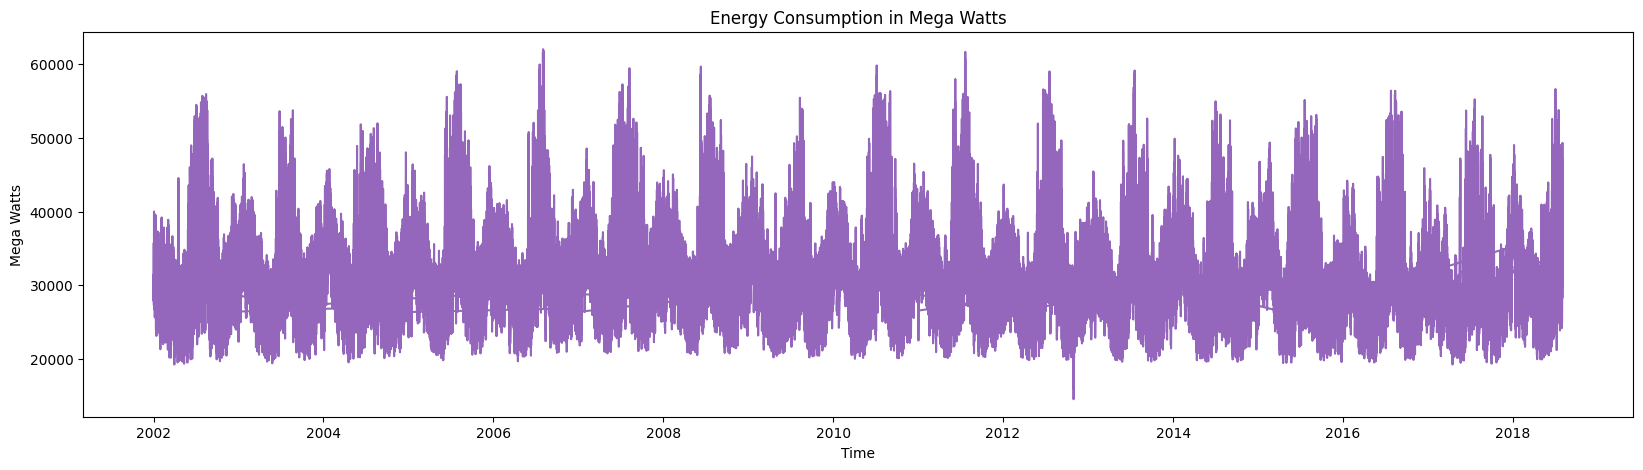

In [6]:
plt.figure(figsize=(20,5))
plt.plot(data,color=palette[4])
plt.xlabel('Time')
plt.ylabel('Mega Watts')
plt.title('Energy Consumption in Mega Watts')

# **TRAINING-TEST DATA SPLIT**

In [7]:
train=data.iloc[data.index<'01-01-2016']
test=data.iloc[data.index>='01-01-2016']

Text(0, 0.5, 'Mega Watts')

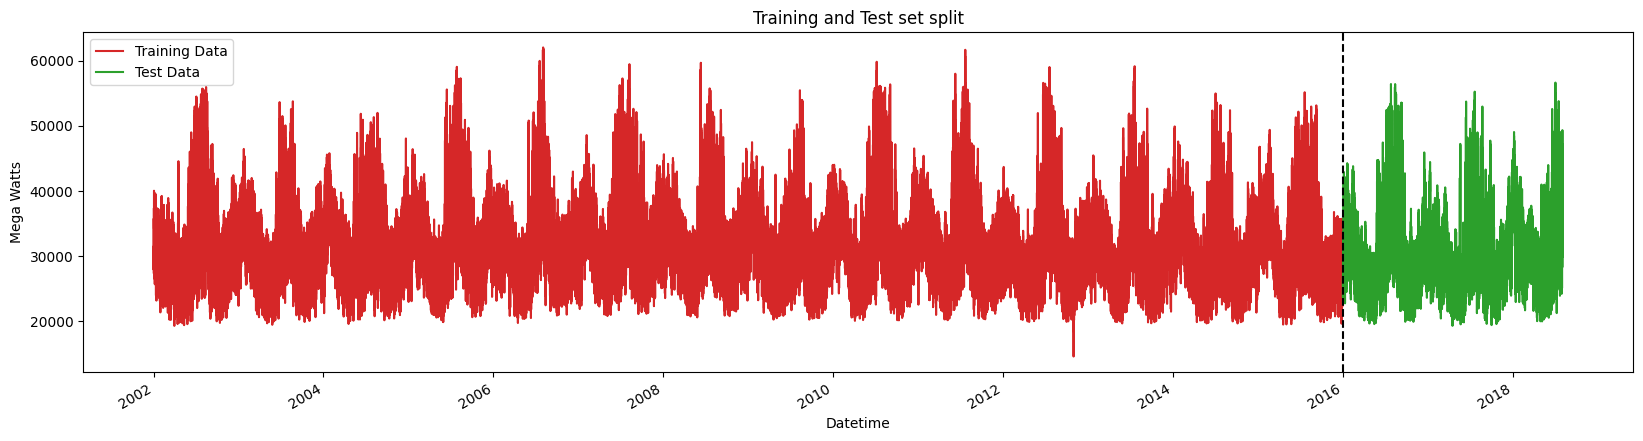

In [8]:
fig,ax=plt.subplots(figsize=(20,5))
train.plot(ax=ax, label='Training data', color=palette[3])
test.plot(ax=ax,label='Test data',color=palette[2])
ax.axvline('01-01-2016',color='black', ls='--')
ax.legend(['Training Data','Test Data'])
plt.title('Training and Test set split')
ax.set_ylabel('Mega Watts')

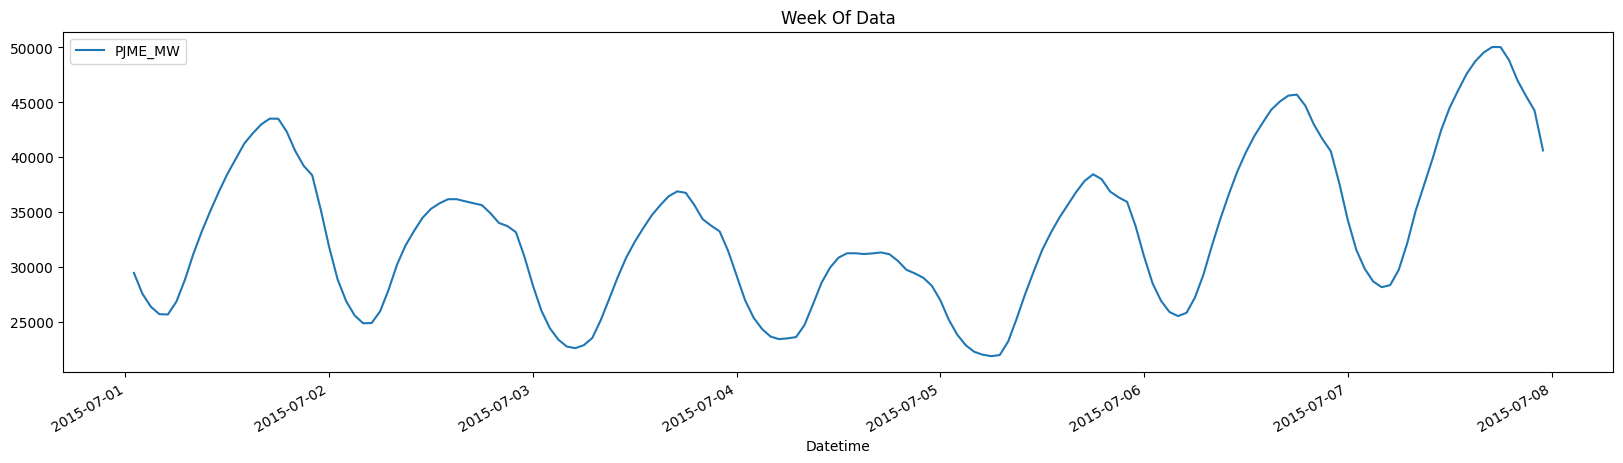

In [9]:
data.loc[(data.index > '07-01-2015') & (data.index < '07-08-2015')].plot(figsize=(20, 5), title='Week Of Data')
plt.show()

# **EXTRACTING TIME-RELATED FEATURES**

In [10]:
def create_new_features(data):
    data=data.copy()
    data['hour']= data.index.hour
    data['DayofWeek']= data.index.dayofweek
    data['quarter']= data.index.quarter
    data['month']= data.index.month
    data['year']= data.index.year
    data['DayofYear']= data.index.dayofyear
    return data

In [11]:
data= create_new_features(data)

In [12]:
data.head(10)

,PJME_MW,hour,DayofWeek,quarter,month,year,DayofYear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
2002-12-31 06:00:00,26222.0,6,1,4,12,2002,365
2002-12-31 07:00:00,28702.0,7,1,4,12,2002,365
2002-12-31 08:00:00,30698.0,8,1,4,12,2002,365
2002-12-31 09:00:00,31800.0,9,1,4,12,2002,365


# **VISUALIZING RELATIONSHIPS**

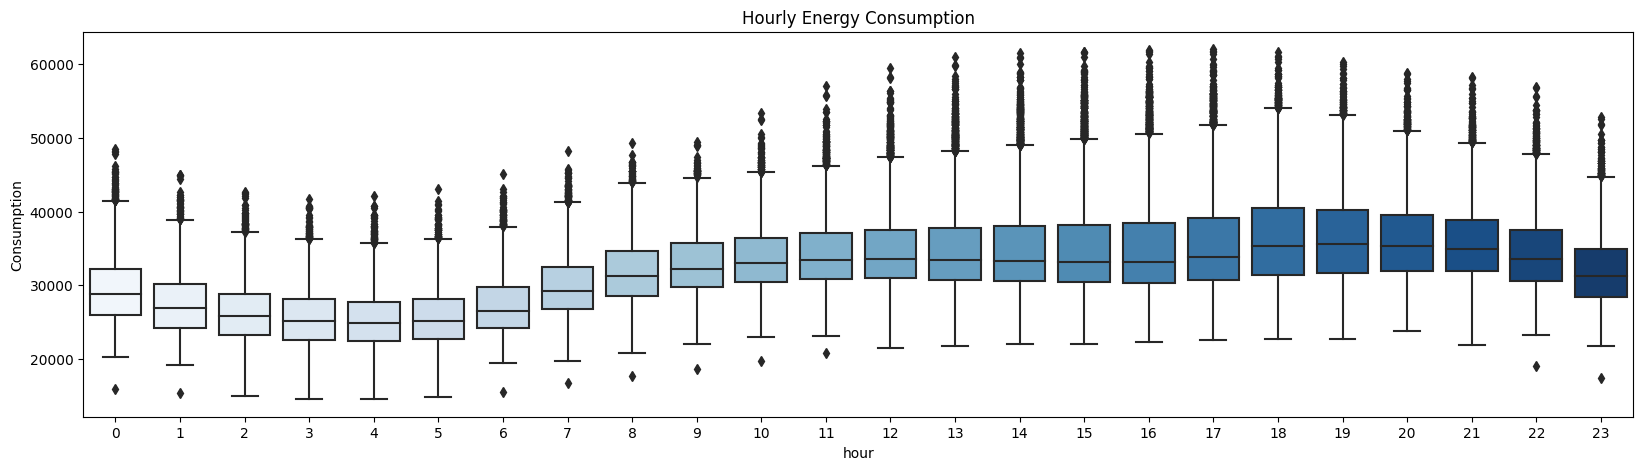

In [13]:
plt.figure(figsize=(20, 5)) 
box=sns.boxplot(data=data,x='hour',y='PJME_MW',palette='Blues')
plt.ylabel('Consumption')
plt.title('Hourly Energy Consumption')
plt.show()

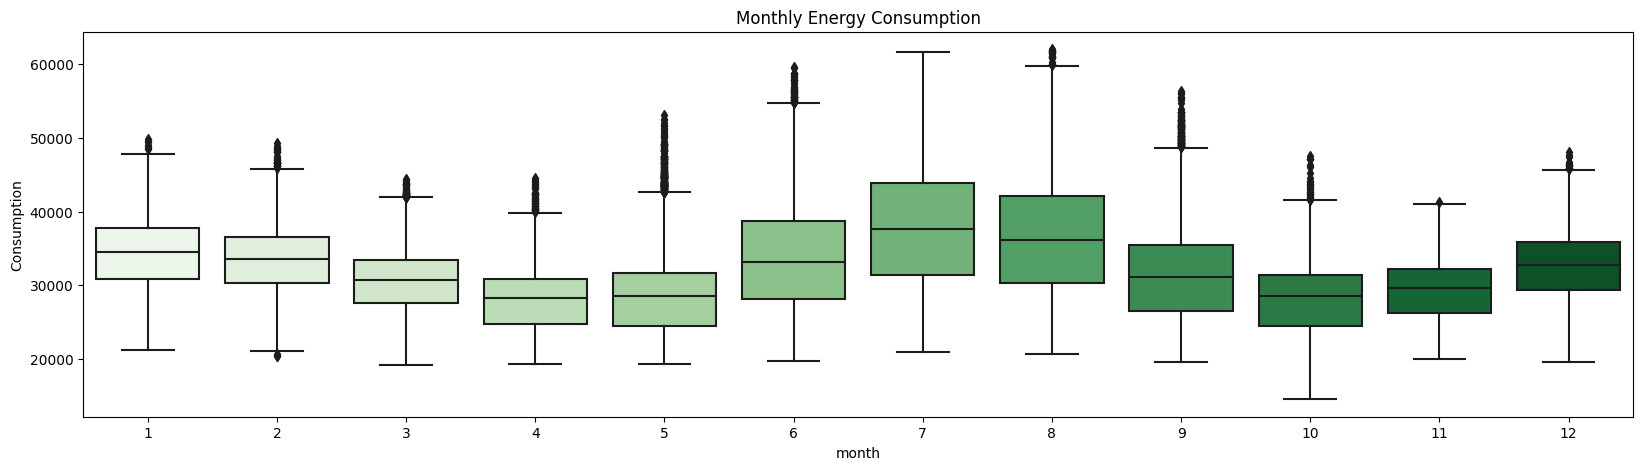

In [14]:
plt.figure(figsize=(20, 5)) 
box=sns.boxplot(data=data,x='month',y='PJME_MW',palette='Greens')
plt.ylabel('Consumption')
plt.title('Monthly Energy Consumption')
plt.show()

# **MODELLING**

In [15]:
train=create_new_features(train)
test=create_new_features(test)

In [16]:
data.columns

Index(['PJME_MW', 'hour', 'DayofWeek', 'quarter', 'month', 'year',
       'DayofYear'],
      dtype='object')

In [17]:
Features=['hour', 'DayofWeek', 'quarter', 'month', 'year',
       'DayofYear']
Target=['PJME_MW']

In [18]:
X_train=train[Features]
Y_train=train[Target]

X_test=test[Features]
Y_test=test[Target]

In [19]:
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)

reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=100)


[0]	validation_0-rmse:6419.51096	validation_1-rmse:6435.35629
[100]	validation_0-rmse:3928.45458	validation_1-rmse:4398.75960
[200]	validation_0-rmse:3259.68128	validation_1-rmse:3998.52623
[300]	validation_0-rmse:3017.45499	validation_1-rmse:3946.56891
[342]	validation_0-rmse:2958.43248	validation_1-rmse:3955.50380


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# **FEATURE IMPORTANCE**

In [20]:
 FI=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['Importance'])

Text(0.5, 1.0, 'Feature vs Importance')

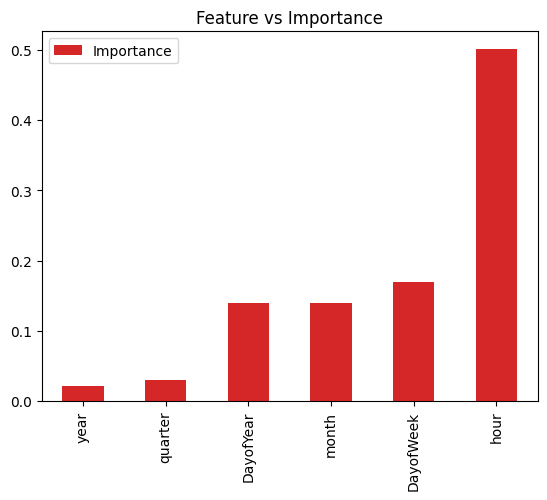

In [21]:
FI.sort_values('Importance').plot(kind='bar',color=palette[3])
plt.title('Feature vs Importance')

# **PREDICTING/FORCASTING**

In [22]:
test['predictions']=reg.predict(X_test)

In [23]:
test

,PJME_MW,hour,DayofWeek,quarter,month,year,DayofYear,predictions
Datetime,,,,,,,,
2016-01-01 00:00:00,26686.0,0,4,1,1,2016,1,32308.826172
2016-12-31 01:00:00,29627.0,1,5,4,12,2016,366,26196.019531
2016-12-31 02:00:00,28744.0,2,5,4,12,2016,366,25353.558594
2016-12-31 03:00:00,28274.0,3,5,4,12,2016,366,25214.070312
2016-12-31 04:00:00,28162.0,4,5,4,12,2016,366,25207.140625
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,38255.222656
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38255.222656
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36803.910156


In [24]:
data=data.merge(test['predictions'],how='left',left_index=True, right_index=True)

In [25]:
data

,PJME_MW,hour,DayofWeek,quarter,month,year,DayofYear,predictions
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42520.046875
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,42203.875000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,40356.597656


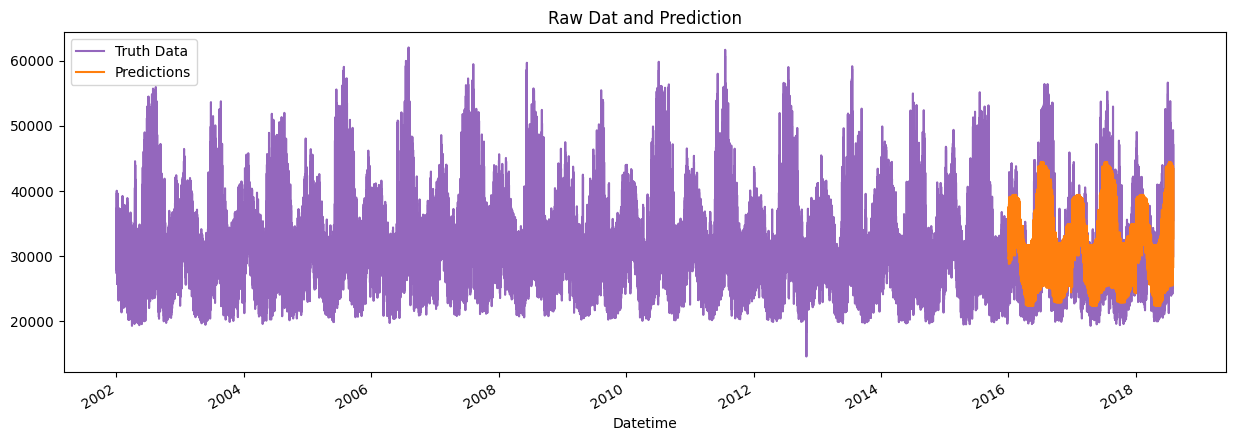

In [26]:
ax = data[['PJME_MW']].plot(figsize=(15, 5),color=palette[4])
data['predictions'].plot(ax=ax, style='-',color=palette[1])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# **PERFORMANCE**

In [27]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3944.54
